# Can we beat the bookmakers?

Using 2019 as test data and our chosen Random Forest model, for matches were odds are available, can we beat the bookmakers?

## Load data and dependencies

In [1]:
import os
import json
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from definitions import GEN_PATH, ROOT_DIR
from utilities.helper import logger

sns.set_context('notebook')
sns.set_style('white')
sns.set(style="whitegrid")

# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])
odds_filepath = os.path.join(GEN_PATH, config['odds_filename'])

# Read data
matches = pd.read_hdf(proc_match_filepath, key='matches')
odds = pd.read_hdf(odds_filepath, key='odds')

# Split data set into train and test, start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400

# Initial model parameters
rf_max_depth = 8
rf_estimators = 100  # future default in sklearn

In [3]:
@logger
def start_pipe(df):
    return df.copy()

@logger
def extract_by_date(df, begin = None, end = None):
    df.dropna(inplace=True)
    
    if begin is None and end is None:
        return df
    elif begin is None:
        return df.loc[df['tourney_date'] < end]
    elif end is None:
        return df.loc[df['tourney_date'] >= begin]
    else:
        return df.loc[(df['tourney_date'] >= begin) & (df['tourney_date'] < end)]
    
@logger
def filter_odds_matches(df, odds):
    def check_match(match, odds):
        match_date = pd.to_datetime(match['tourney_date'], unit='s')
        
        check_mask = (
           (odds['tourney_date'] == match_date) & 
            (odds['winner_id'] == match['player_1']) & 
            (odds['loser_id'] == match['player_2']))
        check = odds.loc[check_mask]
        
        if len(check) == 1:
            match['max_winner'] = check['max_w']
    
        return match
    
    df['max_winner'] = float('nan')
    df = df.apply(check_match, axis=1, args=(odds,))
    df.dropna(inplace=True)
    return df

@logger
def filter_train_columns(df):
    final_columns = ['rel_surface_wins', 'rank_diff', 'points_grad_diff']
    df_y = df['outcome']
    df_x = df.filter(final_columns)
    return df_x, df_y

@logger
def filter_test_columns(df):
    final_columns = ['rel_surface_wins', 'rank_diff', 'points_grad_diff']
    df_y = df['outcome']
    df_odds = df['max_winner']
    df_x = df.filter(final_columns)
    return df_x, df_y, df_odds

X_train, y_train = (matches
    .pipe(start_pipe)
    .pipe(extract_by_date, end=test_date_begin)
    .pipe(filter_train_columns))

X_test, y_test, odds_test = (matches
    .pipe(start_pipe)
    .pipe(extract_by_date, begin=test_date_begin)
    .pipe(filter_odds_matches, odds)
    .pipe(filter_test_columns))

start_pipe took=0:00:00.030068 shape=(119314, 18)
extract_by_date took=0:00:00.036940 shape=(91435, 18)
filter_train_columns took=0:00:00.001284 shape=(91435, 3)(91435,)
start_pipe took=0:00:00.017744 shape=(119314, 18)
extract_by_date took=0:00:00.017251 shape=(26979, 18)
filter_odds_matches took=0:01:08.544556 shape=(1451, 19)
filter_test_columns took=0:00:00.000619 shape=(1451, 3)(1451,)(1451,)


In [4]:
model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Random Forest model accuracy on evaluated matches 63 %
Initial wallet: 100, avg. bets per day: 4, exposure margin: x2.3
Default probability limit: 1.0 ppm, actual default probability: 0.9447004 ppm
2019 year end profit: -100 % with avg. match profit: -0.07 %
Max lost matches in a row: 7, out of total matches: 1451
Max amount lost: 27 SEK


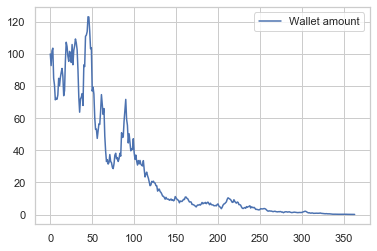

In [17]:
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
correct = predictions*y_test.to_numpy()
correct = (correct + 1) / 2
odds_returns = correct*odds_test.to_numpy()
no_matches = len(odds_returns)
risk_limit = np.power(0.1, 6)
one_million = 1000000

weeks_of_tennis = 52 - 6  # 6 weeks downtime
avg_tournament_length = 5  # days, since most is 250 tournaments
days_of_tennis = weeks_of_tennis * avg_tournament_length
bets_per_day = round(no_matches / days_of_tennis)
avg_matches_per_day = round(no_matches / 365)

initial_wallet = 100
max_lost = 0
max_lost_amount = 0
lost = 0
lost_amount = 0
margin = 2.3;  # size of margin, don't bet all at once
wallet = []
daily_wallet = [initial_wallet]

default_probability = np.power((1 - acc), (bets_per_day * margin))

for i in range(no_matches):
    r = odds_returns[i]
    
    if i == 0:
        prev_wallet = initial_wallet
    else:
        prev_wallet = wallet[i - 1]
    
    bet = prev_wallet / (bets_per_day * margin)
    wallet.append(prev_wallet - bet + r * bet)

    if r == 0:
        lost += 1
        lost_amount += bet
        
        if lost > max_lost:
            max_lost = lost
        
        if lost_amount > max_lost_amount:
            max_lost_amount = lost_amount
    else:
        lost = 0
        lost_amount = 0
    
    if i % avg_matches_per_day == 0:
        daily_wallet.append(wallet[i])
        
year_profit = wallet[-1] / initial_wallet - 1
avg_profit = year_profit / no_matches

print("Random Forest model accuracy on evaluated matches %i %%" % (round(acc*100)))
print(f"Initial wallet: {initial_wallet}, avg. bets per day: {avg_matches_per_day}, exposure margin: x{margin}")
print("Default probability limit: %0.1f ppm, actual default probability: %0.7f ppm" % ((risk_limit * one_million), (default_probability * one_million)))
print("2019 year end profit: %i %% with avg. match profit: %0.2f %%" % ((round(year_profit*100), avg_profit*100)))
print(f"Max lost matches in a row: {max_lost}, out of total matches: {no_matches}")
print("Max amount lost: %i SEK" % max_lost_amount)

daily_wallet = pd.DataFrame(daily_wallet, columns=['Wallet amount'])

sns.lineplot(data=daily_wallet)
plt.show()